In [ ]:
%load_ext nb_black

In [2]:
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
import tensorflow as tf
from typing import Iterable, List
import numpy as np
import math
from SpatialPooler import SpatialPooler
import seaborn as sns
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>

In [22]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

<IPython.core.display.Javascript object>

In [5]:
x_train.shape

(60000, 28, 28)

<IPython.core.display.Javascript object>

In [23]:
sample_size = 1000
x_train, y_train = x_train[:sample_size], y_train[:sample_size]

<IPython.core.display.Javascript object>

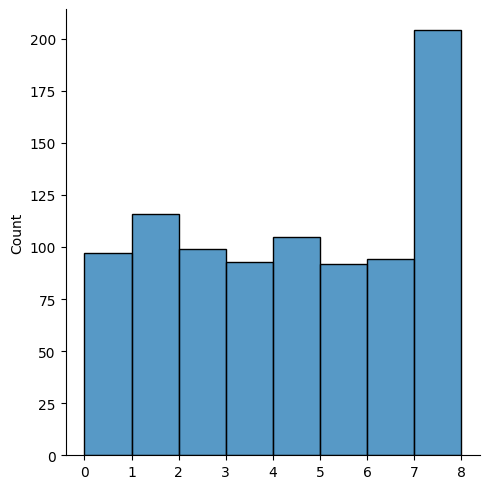

<IPython.core.display.Javascript object>

In [24]:
sns.displot(y_train, bins=(range(0, 9)))

In [25]:
inp_shape = x_train[0].shape
inp_shape

(28, 28)

<IPython.core.display.Javascript object>

<AxesSubplot:>

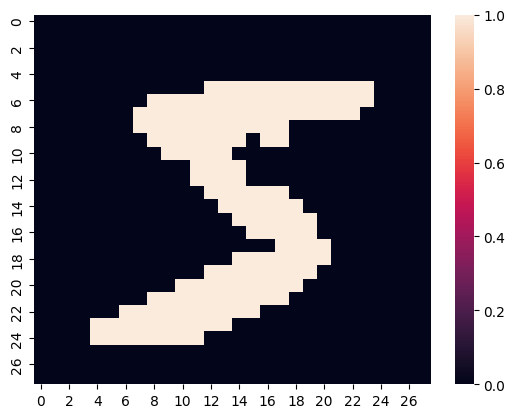

<IPython.core.display.Javascript object>

In [26]:
sample = x_train[0].astype("int32")
sample[sample > 0] = 1
sns.heatmap(sample)

In [27]:
sp = SpatialPooler(
    input_dimension=inp_shape,
    column_dimension=(32, 32),
    connection_sparsity=0.2,
    permanence_threshold=0.5,
    stimulus_threshold=30.0,
    permanence_increment=0.2,
    permanence_decrement=0.1,
    column_sparsity=0.2,
)

<IPython.core.display.Javascript object>

In [28]:
for sample in tqdm(x_train):
    sample = sample.astype("int32")
    sample[sample > 0] = 1

    sp.compute(sample, learn=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [ ]:
sp.save_state("sp_state")

In [46]:
def get_sdrs(samples):
    sdrs = []
    for sample in samples:
        sample = sample.astype("int32")
        sample[sample > 0] = 1
        active_columns = sp.compute(sample, learn=False)
        sdr = sp.top_columns_to_sdr(active_columns)
        sdrs.append(sdr)

    return sdrs

<IPython.core.display.Javascript object>

In [47]:
def calc_overlap(sdr_one, sdr_two):
    return np.sum(np.logical_and(sdr_one, sdr_two).astype(int))

<IPython.core.display.Javascript object>

In [48]:
def get_overlaps(ref_sdr, sdrs):
    overlaps = []
    for sdr in sdrs:
        overlap = calc_overlap(ref_sdr, sdr)
        overlaps.append(overlap)
    return overlaps

<IPython.core.display.Javascript object>

In [49]:
fives = np.argwhere(y_train == 5)[:10]
sixes = np.argwhere(y_train == 6)[:10]
fives = x_train[fives[:, 0]]
sixes = x_train[sixes[:, 0]]

<IPython.core.display.Javascript object>

In [50]:
f_sdrs = get_sdrs(fives)
s_sdrs = get_sdrs(sixes)

<IPython.core.display.Javascript object>

In [51]:
ref = f_sdrs[0]

<IPython.core.display.Javascript object>

In [52]:
fives_overlap = get_overlaps(ref, f_sdrs)

<IPython.core.display.Javascript object>

In [53]:
sixes_overlap = get_overlaps(ref, s_sdrs)

<IPython.core.display.Javascript object>

In [54]:
np.mean(fives_overlap)

76.7

<IPython.core.display.Javascript object>

In [55]:
np.mean(sixes_overlap)

92.2

<IPython.core.display.Javascript object>

<AxesSubplot:>

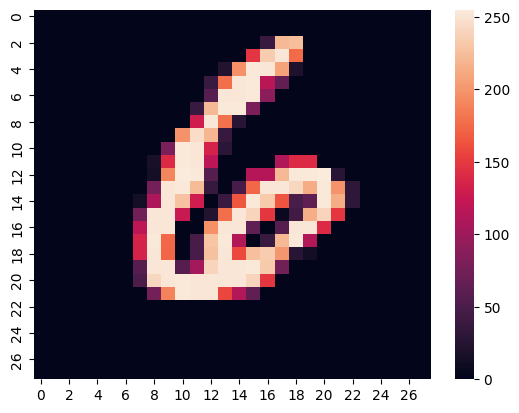

<IPython.core.display.Javascript object>

In [56]:
sns.heatmap(sixes[0])

In [ ]:
# init potential connections to input space for every column / or mini column?
# init permannce value for each potential connection -> uniformly drawn from [0, 1] -> 50% of synapses are connected

# algorithm:
# feedforward input:
# 1. determine overlap of input and columns connected to input space * boosting factor
# 2. column is active if activation is above stimulus threshold
# 3. use kWTA activation globally
# 4. update permance value of active/inactive columns following hebbian style learning
# 5. update boost value by comparing columns to neighbouring columns